In [ ]:
import csv
import random
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.cluster import KMeans
from datetime import datetime
import matplotlib.pyplot as plt

def find_closed_date(dataframe):
  new_columns=dataframe["entityname"].str.split("Dissolved",n=1,expand=True)
  new_columns_delinquent=dataframe["entityname"].str.split("Delinquent",n=1,expand=True)
  dataframe["Closed date dissolved"] = new_columns[1] 
  dataframe["Closed date delinquent"] = new_columns_delinquent[1] 
  dataframe["Closed Date"] = dataframe.apply(lambda row: row["Closed date dissolved"] if row["Closed date dissolved"] != None else row["Closed date delinquent"], axis=1)
  del dataframe["Closed date dissolved"]
  del dataframe["Closed date delinquent"]
  return dataframe

## New version looking for dates using REGEX
# Finds all the date opbjects in the entityname column, chooses the last one
def find_closed_date(dataframe):
    keywords = ['Colorado Authority Relinquished', 'Dissolved', 'Delinquent', 'Withdrawn']
    # Finding [any word] space [two digits] [,] space [four digits]
    long_date_regex = r'\w+\s+\d{1,2},\s+\d{4}'
    # Find all the occurences, and split saving only the last date found
    new_columns = dataframe["entityname"].str.findall(long_date_regex).str[-1]
    # Create a new column to add the formatted closed dates to
    dataframe["Closed Date"] = new_columns.apply(convertDate)
    return dataframe

def convertDate(date: str):
    # Not all rows will be actual dates
    if date == None:
        return date
    try:
        conversion = datetime.strptime(date, '%B %d, %Y')
    except:
        conversion = date
    return conversion

def keep_columns(data: pd.DataFrame, column_names: list) -> pd.DataFrame:
    data = data[column_names]
    return data

def remove_malformed_dates(data: pd.DataFrame, column_name: str) -> pd.DataFrame:
    # Witchcraft
    date_regex = "^(0[1-9]|1[012])[/](0[1-9]|[12][0-9]|3[01])[/](19|20)\d\d$"
    data = data.loc[data[column_name].str.match(date_regex)]
    return data

def remove_before_year(data: pd.DataFrame, column_name: str, year: int) -> pd.DataFrame:
    # Convert the incoming year to a timestamp
    date_before = pd.Timestamp(year, 1, 1)
    # Select rows that are greater than the incoming year, or NaN
    years = data.loc[(data[column_name] > date_before) | (data[column_name].isna())]
    return years

dataframe=pd.read_csv("/content/Business_Entities_in_Colorado.csv",encoding='utf-8')

## Start cleaning up the dataset
# Select the columns we want to keep
columns_to_keep = ['entityid', 'entityname','principaladdress1','principalcity','entitystatus','entitytype','entityformdate']
dataframe = keep_columns(dataframe, columns_to_keep)

In [ ]:
# Remove rows that don't have correctly formed dates in the entity form date column
dataframe = remove_malformed_dates(dataframe, 'entityformdate')

# Remove rows that don't have a principal address
dataframe = dataframe.loc[dataframe['principaladdress1'].notna()]

# Find the date that the business closed within the entityname field
dataframe = find_closed_date(dataframe)

# Convert all of our dates to make them easier to work with
dataframe["Closed Date"].apply(convertDate)
for col_name in ["Closed Date", "entityformdate"]:
    dataframe[col_name] = pd.to_datetime(dataframe[col_name])

# Select only those entries that are within Denver city limits
denver_only = dataframe.loc[dataframe['principalcity'] == 'Denver']
denver_only.to_csv('Business_Entities_in_Colorado_Cleaned.csv')

<ipython-input-3-b2676e474564>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closed_year["Business Lasted"] = (closed_year["Closed Date"] - closed_year['entityformdate']).dt.days.astype('int16')


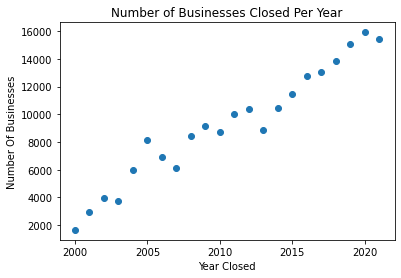

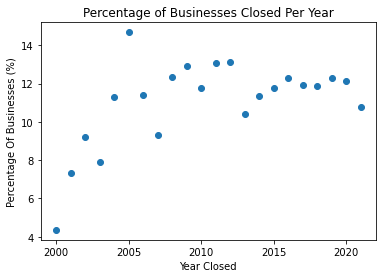

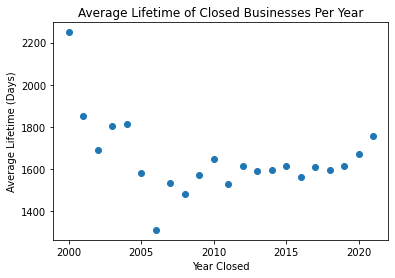

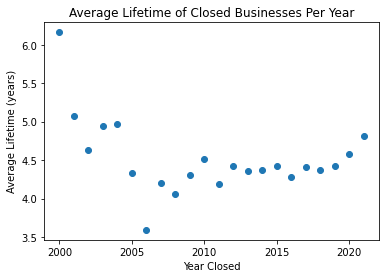

In [ ]:
def closed_per_year_stats(start_date, end_date, closed_businesses):
    # Find the businesses closed in between the given start and end date range
    closed_year = closed_businesses.loc[(closed_businesses["Closed Date"] >= start_date) & (closed_businesses["Closed Date"] < end_date)]
    # Find all businesses that were started before the current end data, and are not closed
    # or closed after the end date year
    not_closed = closed_businesses.loc[(closed_businesses["entityformdate"] < end_date) & 
                                            ((closed_businesses["Closed Date"] > end_date) | (closed_businesses["Closed Date"].isna()))].shape[0]
    # Calculate the number of businesses closed in year
    businesses_closed = closed_year.shape[0]
    # Normalize the value by the number of businesses opened during the year
    businesses_closed_norm = businesses_closed / not_closed
    # Calculate how long the businesses were open for in days
    closed_year["Business Lasted"] = (closed_year["Closed Date"] - closed_year['entityformdate']).dt.days.astype('int16')
    try:
        average = int(closed_year["Business Lasted"].mean())
    except:
        average = 0
    return businesses_closed,businesses_closed_norm, average

def graph_stats(stat_dict,x_title,y_title,title):
    # Create scatter plot for given stats
    plt.scatter(stat_dict.keys(),stat_dict.values())
    plt.title(title)
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.show()

data_dict={"Closed Per Year": {},"Closed Per Year Norm": {}, "Days Open": {}, "Years Open": {}}
for year in range(2000, 2022):
    # Create timestamps for the current year, and year after to slice dataframe
    closed_ts_start = pd.Timestamp(year, 1, 1)
    closed_ts_end = pd.Timestamp((year+1), 1, 1)
    # Calculate the normalized number of businesses closed within the year, and 
    # the average number of days they were in business
    businesses_closed, businesses_closed_norm, avg_days_in_business = closed_per_year_stats(closed_ts_start, closed_ts_end, denver_only)
    # Create 
    data_dict["Closed Per Year"][year] = businesses_closed
    data_dict["Closed Per Year Norm"][year] = businesses_closed_norm*100
    data_dict["Days Open"][year] = avg_days_in_business
    data_dict["Years Open"][year] = avg_days_in_business / 365

# Visualize the different stats calculated
graph_stats(data_dict["Closed Per Year"],"Year Closed","Number Of Businesses","Number of Businesses Closed Per Year")
graph_stats(data_dict["Closed Per Year Norm"],"Year Closed","Percentage Of Businesses (%)","Percentage of Businesses Closed Per Year")
graph_stats(data_dict["Days Open"],"Year Closed","Average Lifetime (Days)","Average Lifetime of Closed Businesses Per Year")
graph_stats(data_dict["Years Open"],"Year Closed","Average Lifetime (years)","Average Lifetime of Closed Businesses Per Year")

In [ ]:
# Remove all entries that shut down before the pandemic
date_before = pd.Timestamp(2020, 3, 1)
denver_only = denver_only.loc[(denver_only["Closed Date"] > date_before) | (denver_only["Closed Date"].isna())]

# Load addresses created by city of denver GIS, found here:
# https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-addresses
addresses = pd.read_csv("addresses.csv", encoding='utf-8')

# Keep only select columns in the addresses dataframe
keep_addr_cols = ['LATITUDE', 'LONGITUDE', 'FULL_ADDRESS']
small_addresses = keep_columns(addresses, keep_addr_cols)

# Rename the new addresses dataframe column to match our existing data for merge
small_addresses = small_addresses.rename(columns={"FULL_ADDRESS": "principaladdress1"})

# Merge the two dataframes together. The new frame will have Lat/Lon
# coordinates based on the address lookup in the addresses dataframe
denver_only = denver_only.merge(small_addresses, on='principaladdress1')
denver_only.to_csv('Business_Entities_in_Denver_Geo.csv')

In [ ]:
# Keep only the lat/lon columns for clustering
lat_lon_cols = ['LATITUDE', 'LONGITUDE']
lat_lon = keep_columns(denver_only, lat_lon_cols)

# Cluster using KMeans. Experimented with other algorithms and kMeans was
# by far the best and created the most meaningful output
num_clusters = 78   # There are 78 neighborhoods in Denver
labels = KMeans(n_clusters=num_clusters, random_state=42).fit_predict(lat_lon.to_numpy())

# Create a new column in the dataframe to save the labels coming from kMeans
denver_only['kmeans_label'] = labels

In [ ]:
# Extremely verbose, but sure way to generate high contrast boundries between clusters
color_list = ['aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'bisque', 
              'black', 'blanchedalmond', 'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 
              'chartreuse', 'chocolate', 'coral', 'cornflowerblue', 'cornsilk', 'crimson', 
              'cyan', 'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgrey', 
              'darkgreen', 'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange', 
              'darkorchid', 'darkred', 'darksalmon', 'darkseagreen', 'darkslateblue', 
              'darkslategray', 'darkslategrey', 'darkturquoise', 'darkviolet', 'deeppink', 
              'deepskyblue', 'dimgray', 'dimgrey', 'dodgerblue', 'firebrick', 'floralwhite', 
              'forestgreen', 'fuchsia', 'gainsboro', 'ghostwhite', 'gold', 'goldenrod', 
              'gray', 'grey', 'green', 'greenyellow', 'honeydew', 'hotpink', 'indianred', 
              'indigo', 'ivory', 'khaki', 'lavender', 'lavenderblush', 'lawngreen', 
              'lemonchiffon', 'lightblue', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 
              'lightgray', 'lightgrey', 'lightgreen', 'lightpink', 'lightsalmon', 'lightseagreen', 
              'lightskyblue', 'lightslategray', 'lightslategrey', 'lightsteelblue', 'lightyellow', 
              'lime', 'limegreen', 'linen', 'magenta', 'maroon', 'mediumaquamarine', 'mediumblue', 
              'mediumorchid', 'mediumpurple', 'mediumseagreen', 'mediumslateblue', 
              'mediumspringgreen', 'mediumturquoise', 'mediumvioletred', 'midnightblue', 'mintcream', 
              'mistyrose', 'moccasin', 'navajowhite', 'navy', 'oldlace', 'olive', 'olivedrab', 'orange', 
              'orangered', 'orchid', 'palegoldenrod', 'palegreen', 'paleturquoise', 'palevioletred',
              'papayawhip', 'peachpuff', 'peru', 'pink', 'plum', 'powderblue', 'purple', 'red', 
              'rosybrown', 'royalblue', 'rebeccapurple', 'saddlebrown', 'salmon', 'sandybrown', 
              'seagreen', 'seashell', 'sienna', 'silver', 'skyblue', 'slateblue', 'slategray', 
              'slategrey', 'snow', 'springgreen', 'steelblue', 'tan', 'teal', 'thistle', 'tomato', 
              'turquoise', 'violet', 'wheat', 'white', 'whitesmoke', 'yellow', 'yellowgreen']
color_dict = {label: random.choice(color_list) for label in set(labels)}
colors = [color_dict[i] for i in labels]

# Create a scatter plot on top of a map using the Lat/Lon coordinates we generated earlier
# Color code the points to reflect the boundries of the newly created clusters
fig = px.scatter_mapbox(denver_only, 
                        lat="LATITUDE", 
                        lon="LONGITUDE",
                        hover_name="principaladdress1", 
                        hover_data=["principaladdress1"],
                        color=colors,
                        zoom=8, 
                        height=800,
                        width=1400)

# Legend doesn't tell us much here
fig.update_traces(showlegend=False, selector=dict(type='scattermapbox'))
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
# Create a new view of the dataframe, this time by selecting all of the businesses
# that have a closed date between the rough start of the pandemic, and slightly
# in the future
date_start = pd.Timestamp(2020, 3, 1)
date_end = pd.Timestamp(2022, 12, 31)

# Our new dataframe will have entries that closed during this timeframe
closed_during_pandemic = denver_only.loc[(denver_only['Closed Date'] > date_start) | (denver_only['Closed Date'] < date_end)]

In [ ]:
# Lets now visualize just these businesses that closed with their existing kMeans labels
colors = [color_dict[i] for i in closed_during_pandemic['kmeans_label']]

fig = px.scatter_mapbox(closed_during_pandemic, 
                        lat="LATITUDE", 
                        lon="LONGITUDE",
                        hover_name="principaladdress1", 
                        hover_data=["principaladdress1"],
                        color=colors,
                        zoom=8, 
                        height=800,
                        width=1400)

fig.update_traces(showlegend=False, selector=dict(type='scattermapbox'))
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
# Now to normalize the results. Because each of the clusters has a varying number of
# businesses, we will divide the number of closes businesses by the total number
# that existed in that cluster. This will show which areas had the highest closure
# rates rather than just raw data
label_counts = {}

for label in labels:
    label_counts[label] = {}
    label_counts[label]['start'] = len(denver_only.loc[denver_only['kmeans_label'] == label])
    label_counts[label]['closed'] = len(closed_during_pandemic.loc[closed_during_pandemic['kmeans_label'] == label])
    label_counts[label]['percentage'] = label_counts[label]['closed'] / label_counts[label]['start']

In [ ]:
# Use the newly calculated closure rates to create a heatmap reflecting which clusters
# had the highest rates of closure
colors = [label_counts[i]['percentage'] for i in closed_during_pandemic['kmeans_label']]

fig = px.scatter_mapbox(closed_during_pandemic, 
                        lat="LATITUDE", 
                        lon="LONGITUDE",
                        hover_name="principaladdress1", 
                        hover_data=["principaladdress1"],
                        color=colors,
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        range_color=[0.0,0.25],
                        zoom=8,
                        height=800,
                        width=1400)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()